In [5]:
import cv2
import glob
import sys
import os
import numpy as np
import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras
from functools import partial
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter

def load_file(path,x,y,x_1,y_1):
    files = glob.glob(path+'./*.jpg')
    if not files:
        print("Chck Phath")
        sys.exit()
    img = []
    for index, i in enumerate(tqdm.tqdm((files))):
        im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)[y:y_1, x:x_1]
        if index == 0:
            ref_img = im
        img.append(np.stack([im, ref_img], axis = 2))
    return np.array(img)

features = load_file('../data/DIC/', 120, 250,220,350)
target = np.array(pd.read_csv('../data/DIC/target.csv', encoding='CP949'))[:,3]
min_max_scaler  = MinMaxScaler()
target = min_max_scaler.fit_transform(target.reshape(-1, 1))
target = savgol_filter(target.flatten(),201,1).reshape(-1, 1)


100%|██████████| 2302/2302 [00:09<00:00, 242.06it/s]


In [2]:
X_train,  X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.15, random_state=0)
X_train = X_train /255.0
X_valid = X_valid / 255.0


In [3]:
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[100, 100, 2]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=1),
])

In [ ]:
model.summary()

In [4]:
model.compile(loss="mse", optimizer="RMSprop", metrics=["mse"])
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))
score = model.evaluate(X_valid, y_valid)

Train on 1956 samples, validate on 346 samples
Epoch 1/30
1956/1956 [==============================] - 11s 6ms/sample - loss: 207.2466 - mse: 207.2467 - val_loss: 0.1196 - val_mse: 0.1196

In [5]:
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]
epoch_count = range(1, len(training_loss)+1)

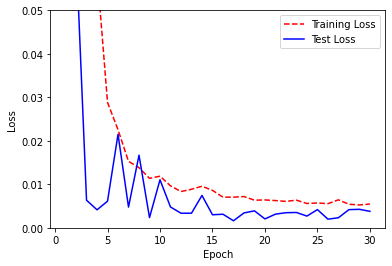

In [6]:
import matplotlib.pyplot as plt
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0,0.05)
plt.show()

In [7]:
predicted_target = model.predict(features/255)

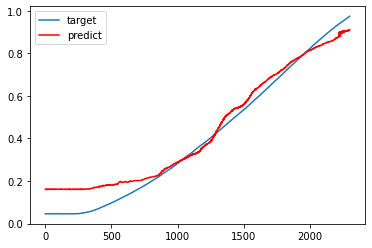

In [8]:
plt.plot(target,label='target')
plt.plot(predicted_target,color='red',label='predict')
plt.legend()

In [ ]:
model.save('DIC.h5')

In [ ]:
np.save('DIC_training_loss',training_loss)
np.save('DIC_test_loss',test_loss)

In [ ]:
ml_training_loss=np.load('ml_training_loss.npy')
ml_testing_loss=np.load('test_loss.npy')

In [ ]:
plt.plot(ml_training_loss)
plt.plot(ml_testing_loss)
plt.plot(epoch_count, training_loss)
plt.plot(epoch_count, test_loss)
plt.ylim(0,0.2)

In [ ]:
import cv2
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
min= MinMaxScaler()


img = features[1][:,:,0]

img2 = features[1900][:,:,0]


fig, ax = plt.subplots()
sns.kdeplot(data=img.ravel(),color='red',label='Ref',ax=ax)
sns.kdeplot(data=img2.ravel(),label='Deformed',ax=ax)

plt.ylabel('number of pixel')
plt.xlabel('pixel value')
ax.set_xlim(20,40)
ax.set_ylim(0.020,0.034)
plt.savefig('sp_zoom.png',bbox='tight')


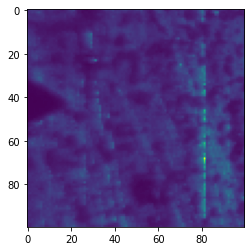

In [6]:
from matplotlib import pyplot as plt
plt.imshow(features[0,:,:,1])

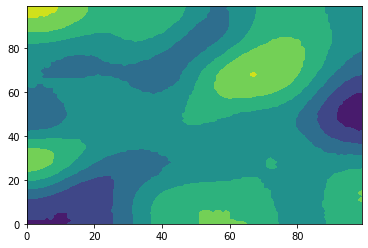

In [18]:
ddd = features[2000,:,:,0]-features[0,:,:,1]
plt.contourf(cv2.GaussianBlur(ddd,(0,0),10))
plt.savefig('abc.png')